In [1]:
# IMPORTACION DE LIBRERIAS
import numpy as np
import pandas as pd

# LIBRERIAS PARA HACER GRAFICOS
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as xp
from matplotlib import style
from mlxtend.plotting import plot_decision_regions

# PREPROCESADO, MODELADO y VALLIDACIÓN 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


# IGNORAMOS LOS WARNING
import warnings
warnings.filterwarnings('ignore')

# ESTILO DE LOS GRÁFICOS
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['axes.titlesize'] = "10"
style.use('ggplot') or plt.style.use('ggplot')

plt_colors = list(sns.color_palette().as_hex())

def plt_color(i):
    return plt_colors[i % len(plt_colors)]

In [2]:
# CARGA Y LIMPIEZA DE DATOS BÁSICO

! [ -f ASI_casoPractico.csv ] || wget https://raw.githubusercontent.com/tuxsy/iebs-master-data-science/main/m04/c2/sprint/ASI_casoPractico.csv

# Cargar el dataset
data = pd.read_csv("ASI_casoPractico.csv", sep=";")

# Eliminar columnas innecesarias
data = data.drop(["ID","b","e","DR"], axis = 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2126 non-null   int64  
 1   AC        2126 non-null   int64  
 2   FM        2126 non-null   int64  
 3   UC        2126 non-null   int64  
 4   ASTV      2126 non-null   int64  
 5   MSTV      2126 non-null   float64
 6   ALTV      2126 non-null   int64  
 7   MLTV      2126 non-null   float64
 8   DL        2126 non-null   int64  
 9   DS        2126 non-null   int64  
 10  DP        2126 non-null   int64  
 11  Width     2126 non-null   int64  
 12  Min       2126 non-null   int64  
 13  Max       2126 non-null   int64  
 14  Nmax      2126 non-null   int64  
 15  Nzeros    2126 non-null   int64  
 16  Mode      2126 non-null   int64  
 17  Mean      2126 non-null   int64  
 18  Median    2126 non-null   int64  
 19  Variance  2126 non-null   int64  
 20  Tendency  2126 non-null   int6

In [3]:
# MUESTREO
X = data.loc[:, data.columns != "Target"]
y = data.loc[:, data.columns == "Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 124)

In [4]:
# SELECCIÓN DE HIPERPARÁMETROS
# Creamos un Grid para probar estos Hiperparámetros
param_grid = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [0.1,1,10]},
    {"kernel": ["linear"], "C": [0.1,1,10]},
    {"kernel": ["poly"], "C": [0.1,1,10], "degree": [2,3]},
]

# Creamos la regilla
grid = GridSearchCV(
        estimator  = SVC(),
        param_grid = param_grid, 
        scoring    = 'roc_auc', # roc_auc, accuracy
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Ajustamos
grid.fit(X = X_train, y = y_train)

# Mostramos los mejoes hiperparámetros según GidSearch

# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')


In [5]:
# ENTRENAMIENTO SVM
svm = SVC(
    C=1, kernel='linear',
    probability=True # Lo necesitamos para calcular la curva ROC
  )

svm.fit(X_train, y_train)

y_pred_train_svm = svm.predict_proba(X_train)
y_pred_test_svm = svm.predict_proba(X_test)

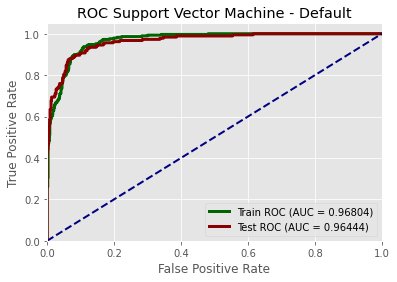

In [6]:
# VALIDACIÓN
#
# Encapsulamos la generación de la curva ROC en una función reutilizable
#
def plot_ROC(y_train, y_test, pred_train, pred_test, title="ROC"):
  # CURVA ROC Y AUC PARA TRAINING
  fpr_train, tpr_train, _ = roc_curve(y_train, pred_train[:, 1])
  roc_auc_train = auc(fpr_train, tpr_train)

  # CURVA ROC Y AUC PARA TEST
  fpr_test, tpr_test, _ = roc_curve(y_test, pred_test[:, 1])
  roc_auc_test = auc(fpr_test, tpr_test)

  # GRAFICA
  plt.figure()
  lw = 2

  plt.plot(fpr_train,tpr_train,color="darkgreen",lw=lw+1,label="Train ROC (AUC = %0.5f)" % roc_auc_train,)
  plt.plot(fpr_test,tpr_test,color="darkred",lw=lw+1,label="Test ROC (AUC = %0.5f)" % roc_auc_test,)

  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

plot_ROC(
    y_train=y_train,
    y_test=y_test,
    pred_train=y_pred_train_svm,
    pred_test=y_pred_test_svm,
    title="ROC Support Vector Machine - Default"
)